# Machine Learning Jobs Dataset Analysis

This notebook performs a detailed analysis of the 1000_ml_jobs_us.csv dataset, which contains information about machine learning job postings in the US.

In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import os
from collections import Counter

# Set style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Display all columns
pd.set_option('display.max_columns', None)

## 1. Loading and Cleaning the Data

In [20]:
# Load the dataset
file_path = '1000_ml_jobs_us.csv'
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# Rename unnamed index column if it exists
if df.columns[0] == 'Unnamed: 0' or df.columns[0] == '':
    df = df.rename(columns={df.columns[0]: 'index'})

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (997, 10)


,index,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training"
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer


In [21]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
missing_values


Missing values per column:


index                         0
job_posted_date               0
company_address_locality     47
company_address_region      113
company_name                  0
company_website              14
company_description          12
job_description_text          1
seniority_level               9
job_title                     0
dtype: int64

In [22]:
# Check column data types
df.dtypes

index                        int64
job_posted_date             object
company_address_locality    object
company_address_region      object
company_name                object
company_website             object
company_description         object
job_description_text        object
seniority_level             object
job_title                   object
dtype: object

In [23]:
# Clean date column - convert to datetime format
# First, filter out invalid dates
valid_date_mask = df['job_posted_date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)
print(f"Rows with valid date format: {valid_date_mask.sum()} out of {len(df)}")

# For valid dates, convert to datetime
df.loc[valid_date_mask, 'job_posted_date'] = pd.to_datetime(
    df.loc[valid_date_mask, 'job_posted_date'], 
    errors='coerce'
)

Rows with valid date format: 997 out of 997


In [24]:
# Clean location data by removing rows with problematic address data
# Identify rows where company_address_region contains actual location data
valid_region_mask = ~df['company_address_region'].str.contains(
    r'•|stay nimble|content creators|welcome big|offices include', 
    na=False, 
    regex=True
)

print(f"Rows with valid region data: {valid_region_mask.sum()} out of {len(df)}")

Rows with valid region data: 997 out of 997


In [25]:
# Create a clean dataset for analysis
df_clean = df[valid_date_mask & valid_region_mask].copy()
print(f"Shape of cleaned dataset: {df_clean.shape}")

# Normalize state names (convert 'CA' to 'California', etc.)
state_mapping = {
    'CA': 'California',
    'NY': 'New York',
    'WA': 'Washington',
    'MA': 'Massachusetts',
    'TX': 'Texas',
    'FL': 'Florida',
    'IL': 'Illinois',
    'PA': 'Pennsylvania',
    'VA': 'Virginia',
    'NC': 'North Carolina',
    'GA': 'Georgia',
    'OH': 'Ohio',
    'MI': 'Michigan',
    'CO': 'Colorado',
    'NJ': 'New Jersey'
}

# Apply mapping for state abbreviations
df_clean['normalized_region'] = df_clean['company_address_region'].map(
    lambda x: state_mapping.get(x, x)
)

df_clean.head()

Shape of cleaned dataset: (997, 10)


,index,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,normalized_region
0,0,2024-10-31 00:00:00,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...,Indiana
1,1,2025-03-14 00:00:00,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer,California
2,2,2025-04-09 00:00:00,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer,California
3,3,2025-03-22 00:00:00,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training",California
4,4,2025-03-28 00:00:00,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer,Massachusetts


## 2. Temporal Analysis

In [28]:
# Ensure 'job_posted_date' is in datetime format
df_clean['job_posted_date'] = pd.to_datetime(df_clean['job_posted_date'], errors='coerce')

# Only analyze rows with valid dates
temp_df = df_clean[df_clean['job_posted_date'].notna()].copy()

# Add month-year column for aggregation
temp_df['month_year'] = temp_df['job_posted_date'].dt.strftime('%Y-%m')

# Count job postings by month
monthly_counts = temp_df.groupby('month_year').size()

print("\nJob postings by month:")
monthly_counts



Job postings by month:


month_year
2022-12      1
2023-11      2
2024-03      1
2024-05      1
2024-06      7
2024-07      3
2024-08      6
2024-09      4
2024-10      8
2024-11     13
2024-12     31
2025-01     28
2025-02     34
2025-03    425
2025-04    433
dtype: int64

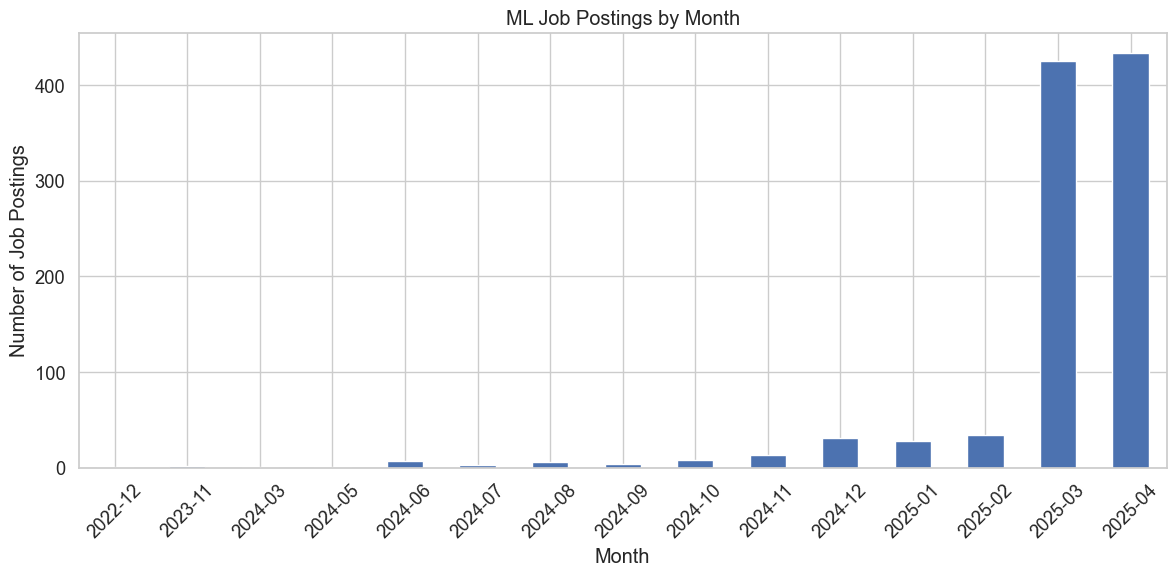

In [29]:
# Plot time series of job postings
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar')
plt.title('ML Job Postings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Check if there are future dated job postings
current_date = datetime.now()
future_postings = temp_df[temp_df['job_posted_date'] > current_date]

print(f"Number of future-dated job postings: {len(future_postings)}")

# View date range
min_date = temp_df['job_posted_date'].min()
max_date = temp_df['job_posted_date'].max()

print(f"Date range: {min_date} to {max_date}")

Number of future-dated job postings: 0
Date range: 2022-12-20 00:00:00 to 2025-04-09 00:00:00


## 3. Geographical Analysis

In [31]:
# Count job postings by state/region
region_counts = df_clean['normalized_region'].value_counts().head(15)

print("\nTop 15 states/regions by job count:")
region_counts


Top 15 states/regions by job count:


normalized_region
California       489
New York          49
Washington        42
Massachusetts     38
Texas             23
Florida           20
Virginia          16
New Jersey        14
England           14
Colorado          11
MD                10
London            10
Pennsylvania       9
Illinois           8
Georgia            7
Name: count, dtype: int64

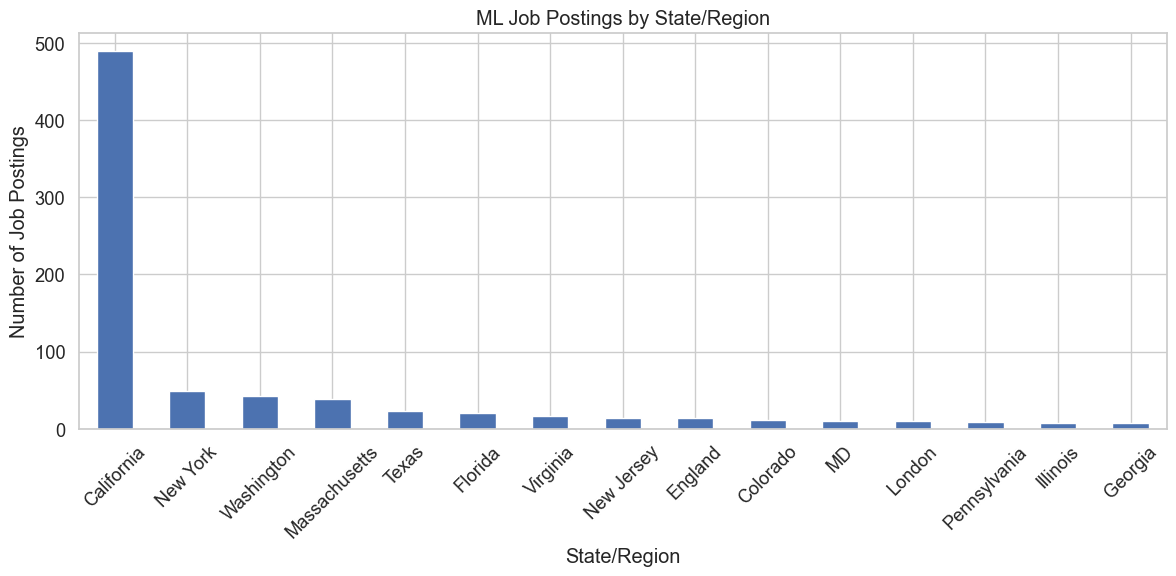

In [32]:
# Plot geographical distribution
plt.figure(figsize=(12, 6))
region_counts.plot(kind='bar')
plt.title('ML Job Postings by State/Region')
plt.xlabel('State/Region')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Count job postings by city (locality)
city_counts = df_clean['company_address_locality'].value_counts().head(15)

print("\nTop 15 cities by job count:")
city_counts


Top 15 cities by job count:


company_address_locality
San Francisco    148
Los Angeles       93
New York          54
Menlo Park        43
San Jose          38
Seattle           37
Mountain View     34
London            25
Boston            21
Santa Monica      20
Palo Alto         19
Los Gatos         17
Santa Clara       12
Camarillo          8
Cambridge          8
Name: count, dtype: int64

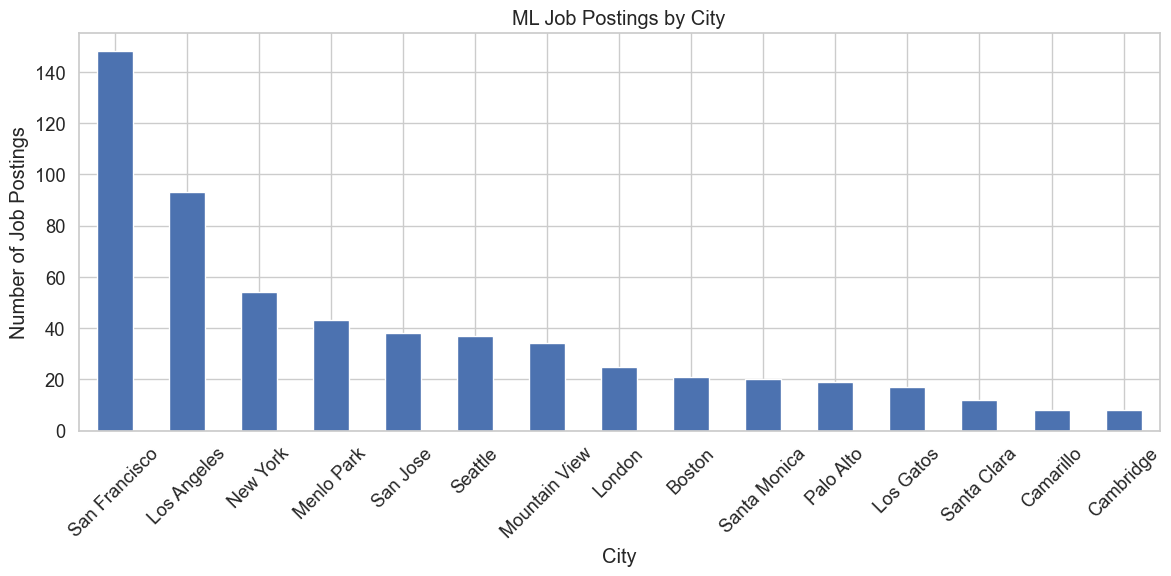

In [34]:
# Plot city distribution
plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar')
plt.title('ML Job Postings by City')
plt.xlabel('City')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Company Analysis

In [35]:
# Count job postings by company
company_counts = df_clean['company_name'].value_counts().head(20)

print("\nTop 20 companies by job count:")
company_counts


Top 20 companies by job count:


company_name
TikTok                       88
Meta                         39
Snap Inc.                    18
Adobe                        18
Splunk                       18
Netflix                      17
DoorDash                     17
Amazon                       15
Amazon Web Services (AWS)    13
Slack                        11
Waymo                        11
Semtech                       8
Tombras                       6
Intuit                        6
Harnham                       6
Cisco                         6
Notion                        6
DigitalOcean                  5
Interclypse                   5
Google                        5
Name: count, dtype: int64

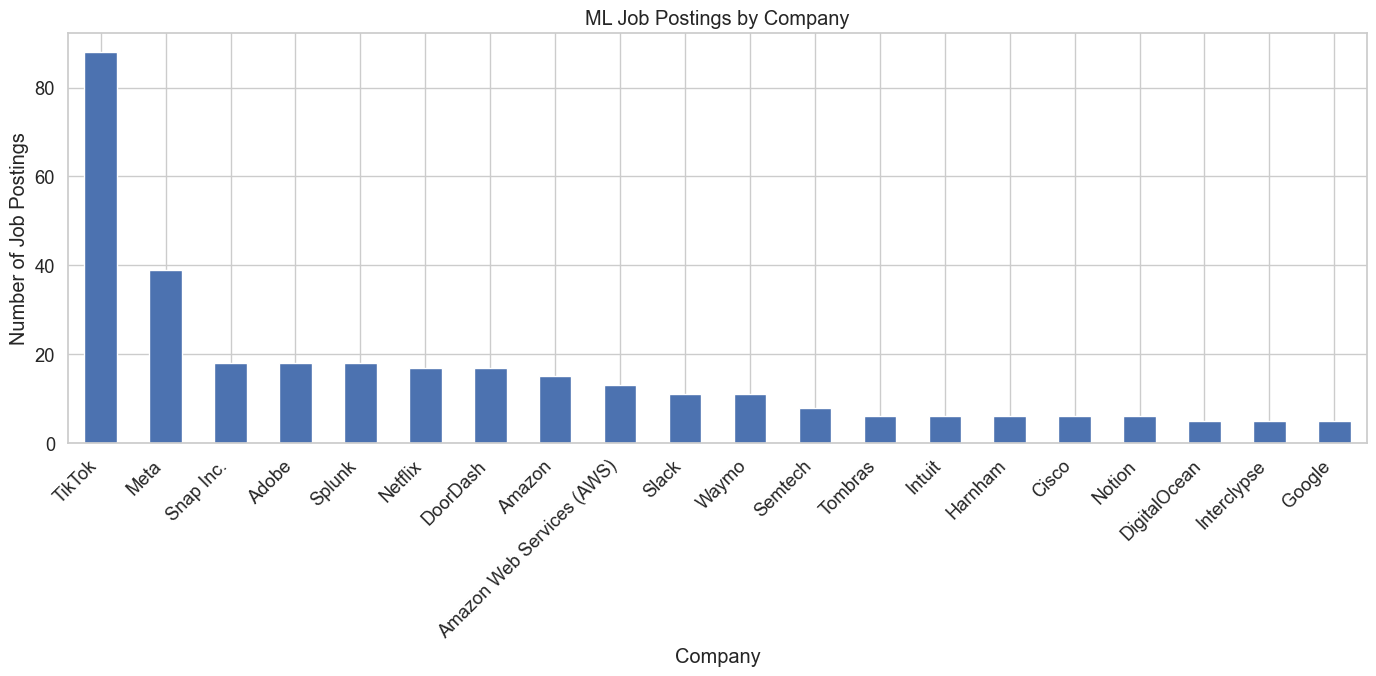

In [36]:
# Plot company distribution
plt.figure(figsize=(14, 7))
company_counts.plot(kind='bar')
plt.title('ML Job Postings by Company')
plt.xlabel('Company')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Job Title Analysis

In [37]:
# Count occurrences of common ML roles in job titles
ml_roles = [
    'Machine Learning', 'ML', 'Data Scientist', 'Data Science',
    'AI Engineer', 'AI Scientist', 'AI Researcher',
    'Deep Learning', 'NLP', 'Computer Vision',
    'Data Engineer', 'Research Scientist', 'Research Engineer',
    'AI/ML', 'ML/AI'
]

role_counts = {}
for role in ml_roles:
    role_counts[role] = df_clean['job_title'].str.contains(role, case=False).sum()

role_df = pd.Series(role_counts).sort_values(ascending=False)

print("\nOccurrences of common ML roles in job titles:")
role_df


Occurrences of common ML roles in job titles:


Machine Learning      729
Data Scientist        131
ML                     80
AI/ML                  23
Data Engineer          12
Data Science           11
NLP                     9
Computer Vision         9
AI Engineer             5
Research Engineer       4
Research Scientist      2
Deep Learning           1
AI Scientist            0
AI Researcher           0
ML/AI                   0
dtype: int64

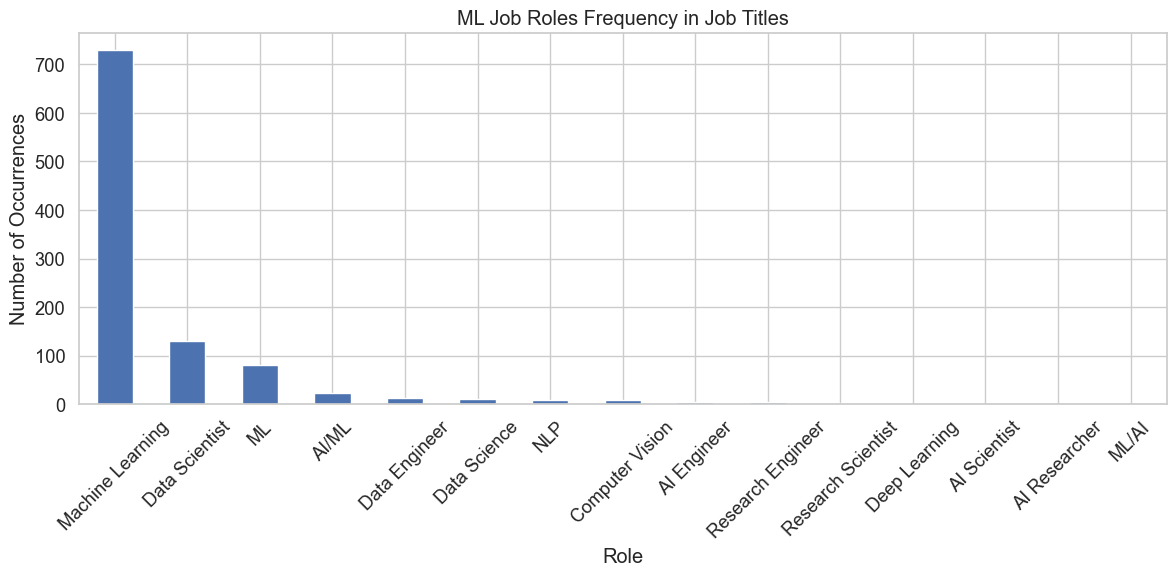

In [38]:
# Plot role distribution
plt.figure(figsize=(12, 6))
role_df.plot(kind='bar')
plt.title('ML Job Roles Frequency in Job Titles')
plt.xlabel('Role')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Create word cloud of job titles (optional - uncomment if wordcloud is installed)
'''
from wordcloud import WordCloud

all_titles = ' '.join(df_clean['job_title'].dropna())

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100,
    contour_width=3,
    contour_color='steelblue'
).generate(all_titles)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Titles')
plt.tight_layout()
plt.show()
'''

"\nfrom wordcloud import WordCloud\n\nall_titles = ' '.join(df_clean['job_title'].dropna())\n\nwordcloud = WordCloud(\n    width=800, height=400,\n    background_color='white',\n    max_words=100,\n    contour_width=3,\n    contour_color='steelblue'\n).generate(all_titles)\n\nplt.figure(figsize=(10, 6))\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud of Job Titles')\nplt.tight_layout()\nplt.show()\n"

## 6. Seniority Level Analysis

In [40]:
# Filter out rows with clearly invalid seniority data
valid_seniority_mask = ~df_clean['seniority_level'].str.contains(
    r'learn about|compelling experiences|films and games|elastic|data regression', 
    na=False, 
    regex=True
)

seniority_df = df_clean[valid_seniority_mask].copy()

# Count job postings by seniority level
seniority_counts = seniority_df['seniority_level'].value_counts().head(10)

print("\nTop 10 seniority levels:")
seniority_counts


Top 10 seniority levels:


seniority_level
Mid-Senior level    371
Entry level         300
Not Applicable      209
Internship           70
Associate            32
Director              5
Executive             1
Name: count, dtype: int64

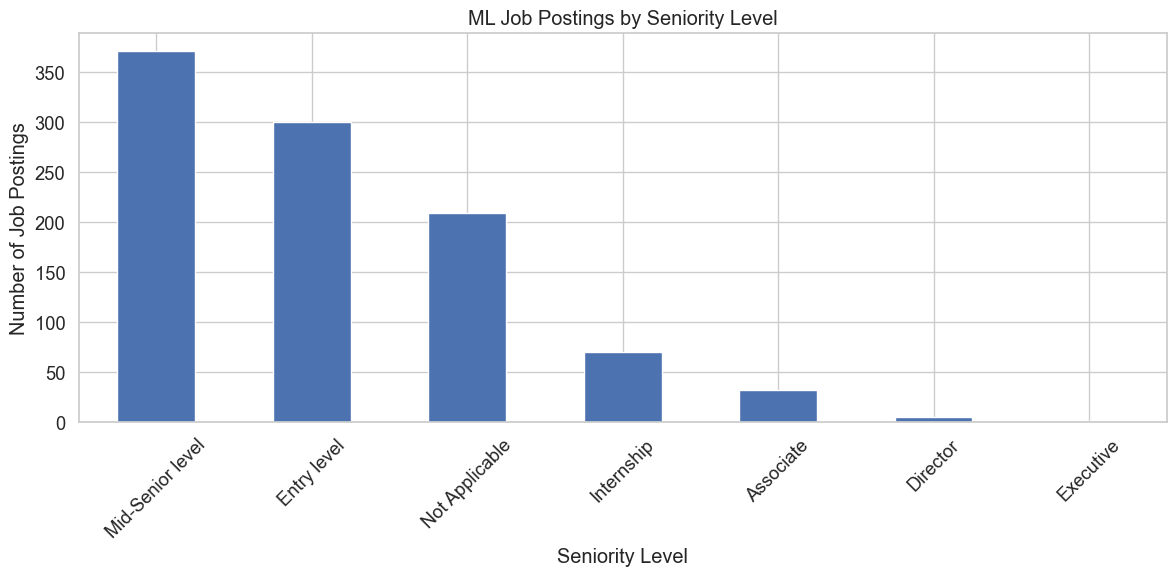

In [41]:
# Plot seniority distribution
plt.figure(figsize=(12, 6))
seniority_counts.plot(kind='bar')
plt.title('ML Job Postings by Seniority Level')
plt.xlabel('Seniority Level')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Job Description Analysis

In [46]:
# Common ML and data science skills
skills = [
    'Python', 'R', 'SQL', 'Java', 'C\+\+', 'Scala', 'Julia',
    'TensorFlow', 'PyTorch', 'Keras', 'scikit-learn', 'sklearn',
    'Pandas', 'NumPy', 'SciPy', 'Matplotlib', 'Seaborn',
    'AWS', 'GCP', 'Azure', 'Cloud',
    'Spark', 'Hadoop', 'Big Data', 'Kafka', 'Airflow',
    'Docker', 'Kubernetes', 'Git',
    'Deep Learning', 'Neural Networks', 'NLP', 'Computer Vision',
    'Reinforcement Learning', 'Generative AI', 'LLM',
    'Statistics', 'Mathematics', 'Algorithms', 'Masters', 'PhD'
]

skill_counts = {}
for skill in skills:
    pattern = re.compile(r'\b' + skill + r'\b', re.IGNORECASE)
    skill_counts[skill] = df_clean['job_description_text'].str.contains(pattern, regex=True, na=False).sum()

skill_df = pd.Series(skill_counts).sort_values(ascending=False)

print("\nTop skills mentioned in job descriptions:")
skill_df.head(20)

<>:3: SyntaxWarning: invalid escape sequence '\+'
<>:3: SyntaxWarning: invalid escape sequence '\+'
/var/folders/hb/xmf_1frx7cxbf9svk6bbz2hh0000gp/T/ipykernel_57380/414430263.py:3: SyntaxWarning: invalid escape sequence '\+'
  'Python', 'R', 'SQL', 'Java', 'C\+\+', 'Scala', 'Julia',



Top skills mentioned in job descriptions:


Python             716
PyTorch            447
Algorithms         377
TensorFlow         373
Cloud              370
AWS                289
Deep Learning      285
SQL                227
Statistics         212
Spark              210
NLP                186
PhD                180
LLM                174
Azure              164
GCP                163
Generative AI      156
Computer Vision    150
Mathematics        149
Java               146
R                  128
dtype: int64

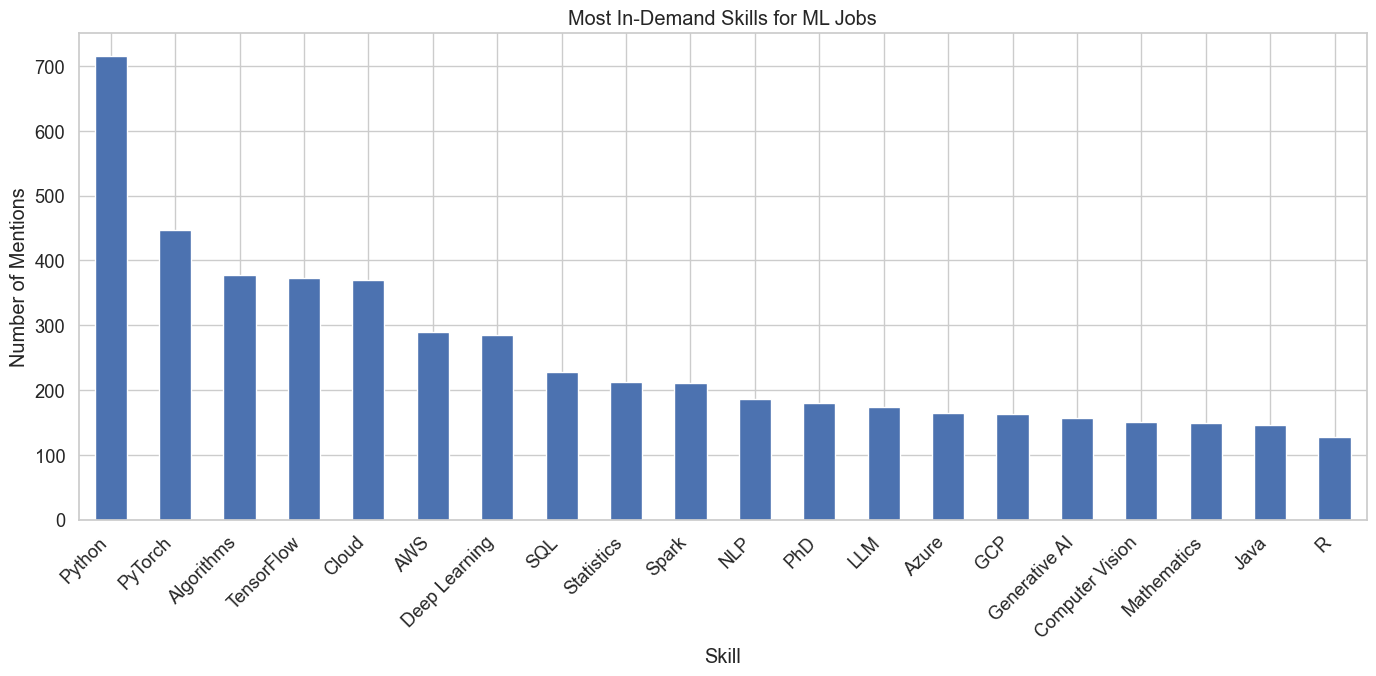

In [47]:
# Plot top skills
plt.figure(figsize=(14, 7))
skill_df.head(20).plot(kind='bar')
plt.title('Most In-Demand Skills for ML Jobs')
plt.xlabel('Skill')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
# Create word cloud of job descriptions (optional - uncomment if wordcloud is installed)
'''
from wordcloud import WordCloud

# Use a sample of descriptions to prevent memory issues
sample_descriptions = ' '.join(df_clean['job_description_text'].dropna().sample(n=min(100, len(df_clean))))

# Remove common words and characters
words_to_remove = ['experience', 'work', 'team', 'skills', 'job', 'role', 'will', 
                    'company', 'working', 'data', 'required', 'years', 'knowledge']

for word in words_to_remove:
    sample_descriptions = re.sub(r'\b' + word + r'\b', '', sample_descriptions, flags=re.IGNORECASE)

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100,
    contour_width=3,
    contour_color='steelblue'
).generate(sample_descriptions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Descriptions')
plt.tight_layout()
plt.show()
'''

"\nfrom wordcloud import WordCloud\n\n# Use a sample of descriptions to prevent memory issues\nsample_descriptions = ' '.join(df_clean['job_description_text'].dropna().sample(n=min(100, len(df_clean))))\n\n# Remove common words and characters\nwords_to_remove = ['experience', 'work', 'team', 'skills', 'job', 'role', 'will', \n                    'company', 'working', 'data', 'required', 'years', 'knowledge']\n\nfor word in words_to_remove:\n    sample_descriptions = re.sub(r'\x08' + word + r'\x08', '', sample_descriptions, flags=re.IGNORECASE)\n\nwordcloud = WordCloud(\n    width=800, height=400,\n    background_color='white',\n    max_words=100,\n    contour_width=3,\n    contour_color='steelblue'\n).generate(sample_descriptions)\n\nplt.figure(figsize=(10, 6))\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud of Job Descriptions')\nplt.tight_layout()\nplt.show()\n"

## 8. Summary

In [48]:
# Create a summary DataFrame for quick reference
summary = pd.DataFrame({
    'Total Rows': [len(df)],
    'Rows After Cleaning': [len(df_clean)],
    'Date Range': [f"{df_clean['job_posted_date'].min()} to {df_clean['job_posted_date'].max()}"],
    'Top State': [df_clean['normalized_region'].value_counts().index[0]],
    'Top City': [df_clean['company_address_locality'].value_counts().index[0]],
    'Top Company': [df_clean['company_name'].value_counts().index[0]],
    'Top Skill': [skill_df.index[0]]
})

summary

,Total Rows,Rows After Cleaning,Date Range,Top State,Top City,Top Company,Top Skill
0,997,997,2022-12-20 00:00:00 to 2025-04-09 00:00:00,California,San Francisco,TikTok,Python
